In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pickle

### Simulated Example

Here we simulate summary statistics (zscores) on ~2000 SNPs across 10 tissues.

There are 4 causal SNPs in the sumation active it tissues[0-1], [2-5], [4-8], [0-8] respectively. The final tissue has no causal SNPs active in it.

In [8]:
Sigma, causal_snps, tissue_membership, causal = pickle.load(open('../simulation_scripts/T10_simulation', 'rb'))
T, N = causal.shape

effectsize = 10  # zscore @ causal snps

Sigma_reg = (Sigma + np.eye(N)*1e-6) / (1+1e-6)
chol = np.linalg.cholesky(Sigma_reg)

# simulate data according to MVN distribution of marignal test statistics
Y = (effectsize * Sigma @ causal.T + chol @ np.random.normal(size=causal.T.shape)).T
X = Sigma_reg

FileNotFoundError: [Errno 2] No such file or directory: '../simulation_scripts/T10_simulation'

### Setting up the model
There are three parameters you need to specify.
1. `K` is the max number of components.
2. `prior_activity` is an array of length `K` with the prior probability that a tissues is active in each component. 
3. `prior_variance` is the prior variance on the entries of the weight matrix. This parameters can have a large impact on the performance of the algorithm. The variation approximmation $q(\{w_{tk}, s_{tk}\})$ is a mixture of two gaussians-- an approximate posterior to $p(w_{tk} | s_{tk} = 1)$ and $p(w_{tk} | s_{tk} = 0) = p(w_{tk})$. It turns out that the variance of the first distribution is determined by `prior_variance`-- small setting will result in harder assignments

There are two pieces of data you need to provide to the model 
1. `X` is the $N \times N$ LD matrix
2. `Y` is a $T \times N$ matrix of z-scores for each SNP in T tissues

You can also provide labels $\text{snp_ids}$ and $\text{tissue_ids}$ that will make the output of the model easier to read

There is no reason the model can't support NAN entries in $Y$ but that needs to implemented


### Training the model

To train the model we use a forward selection scheme on the variational parameters. That is, we first train the model as if there were only one component with various initializations. We select the best model in terms of the evidence lower bound. We then train the model as through there were two components with various initializations, and again select the model with the best ELBO. We proceed until we are learning the full model with K models.

This approach is always increasing in the elbo. In the lth step we are simply performing coordinate ascent on the variaional parameters except that the last $(K-l)$ components are  fixed at a setting where they are irrelevant/inactive. While this is considerably slower than training everything at once, we hope it avoids a lot of poor local optima. Specifically, we hope this avoids the scenario where two components capture the same effect. At a forward step, the elbo will prefer a model that describes new areas of the data to an model that captures the same effect.

We also think this is necessary since the terminal state of the component is extremely sensitive to initialization of the weights. The simple solution is that for each initialization we assign a weight of 1 to one tissue and 0 to the others-- this initialization is destined to find a component that includes the active tissue. Do this across all tissues and select the best initialization.

`forward_fit(early_stop=True)` uses the forward selection type optimization scheme as described above. For now, I suggest using this as it seems to give the type of results we want. `early_stop` is an option that, if at a step of optimization you learn that a component is essentially inactive, we will zero out assigments for all future components and only fit the model one final time.

`fit()` just trains the model from one random initialization. It is much faster, but the results are much less stable since this model is quite sensitive to initialization of `weights` and `activity`

In [5]:
from cafeh.cafeh_genotype import CAFEHG
from cafeh.cafeh_summary import CAFEH

In [6]:
from sklearn.cluster import KMeansME

ImportError: cannot import name 'KMeansME' from 'sklearn.cluster' (/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/cluster/__init__.py)

In [ ]:
K = 20
prior_activity = np.exp(-1*np.linspace(3, 3, K))
#prior_activity = np.ones(K) * 0.6
prior_variance = 10.0

model = SpikeSlabSER(
    X=X, Y=Y, K=K,
    snp_ids=np.arange(N), tissue_ids=np.arange(T),
    prior_activity=prior_activity,
    prior_variance=prior_variance
)

Forward fit, learning 1 components


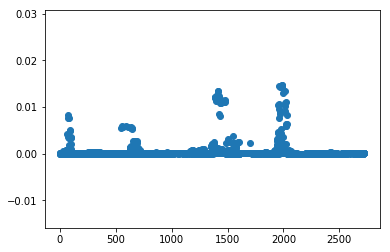

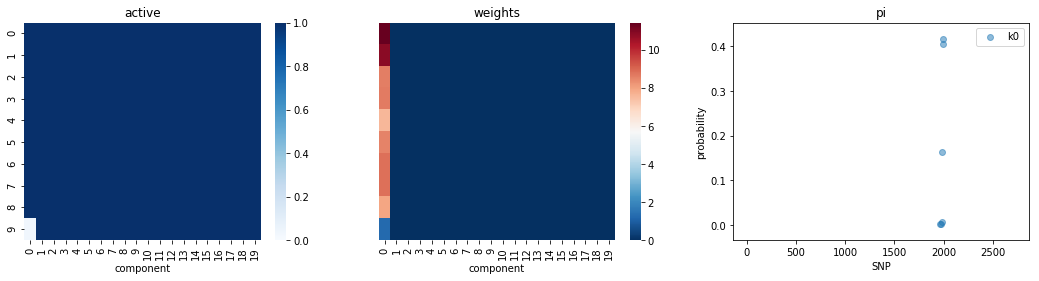

Forward fit, learning 2 components


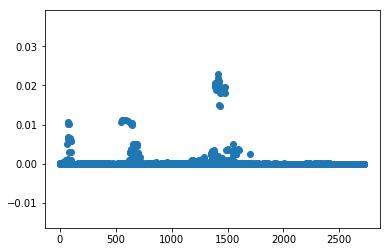

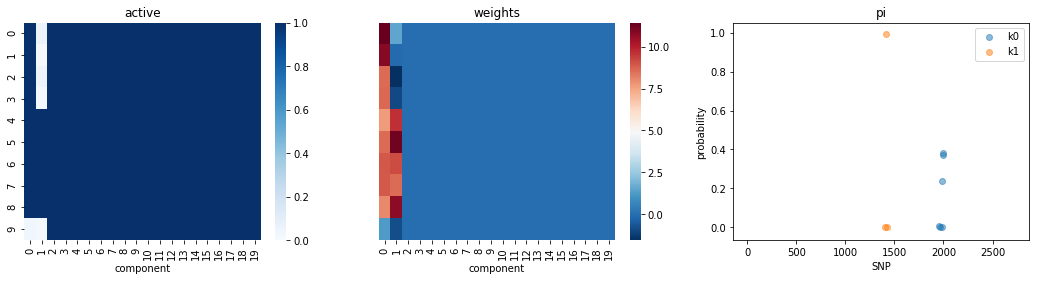

Forward fit, learning 3 components


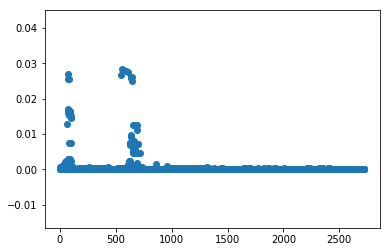

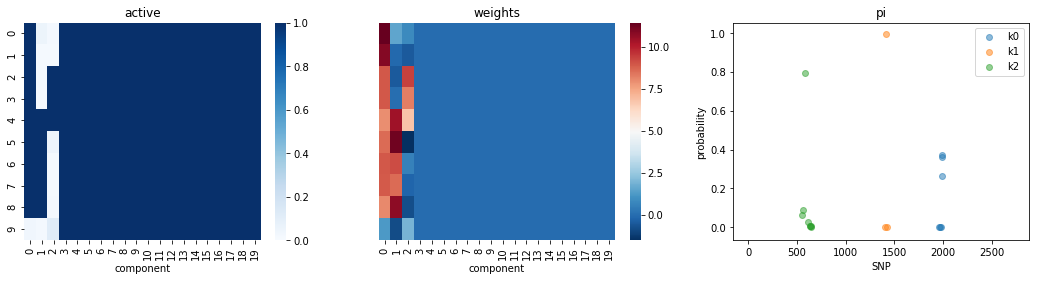

Forward fit, learning 4 components


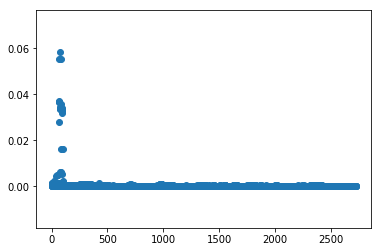

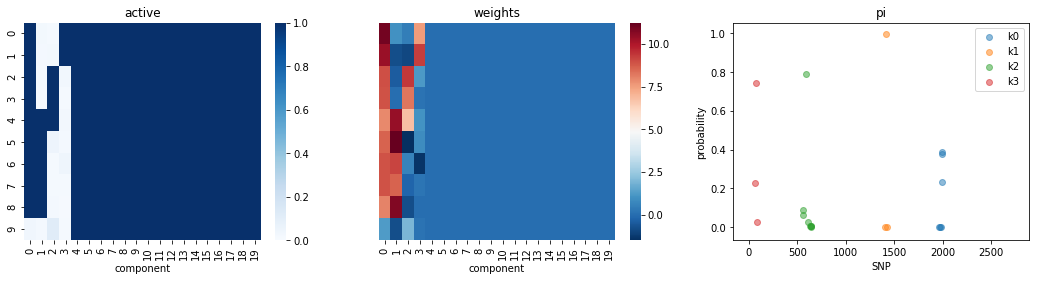

Forward fit, learning 5 components


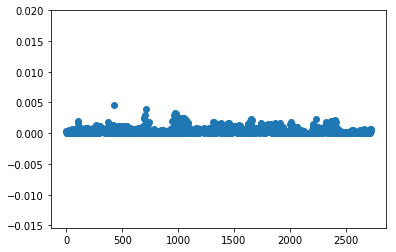

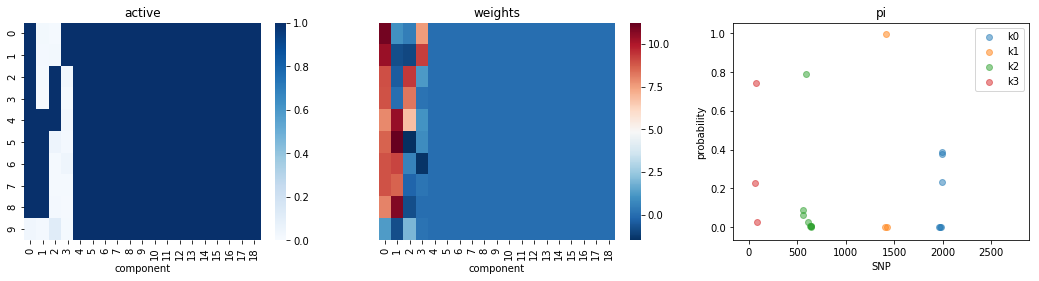

learned inactive cluster, finalizing parameters


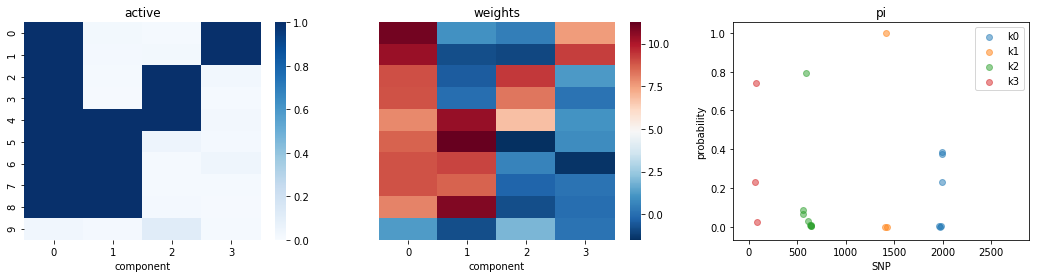

CPU times: user 39.4 s, sys: 219 ms, total: 39.6 s
Wall time: 12.9 s


In [70]:
%%time
model.forward_fit(early_stop=True, plots=True, max_inner_iter=1)

### Plots

Example call of different plotting functions

`plot_component(thresh=0.1)` plots the probability of using a component, weights of each component per tissue, and the posterior categorical distributions of each active component, components which have $p(\text{tissue t active in component k}) > \text{thresh}$ for some tissue

`plot_predictions()` in the first row superimposes the observed z scores (black crosses) and expected value under the trained model (red circles), in the second row plots predictions against observed z scores

`plot_manhattan(component, thresh=0.0)` makes manhattan plots for a component, colored by r^2 with the top snp in that component. `thresh` is a minimum probability to include a tissue in the plot. Tissues are plotted in decreasing order of probability of using `component`

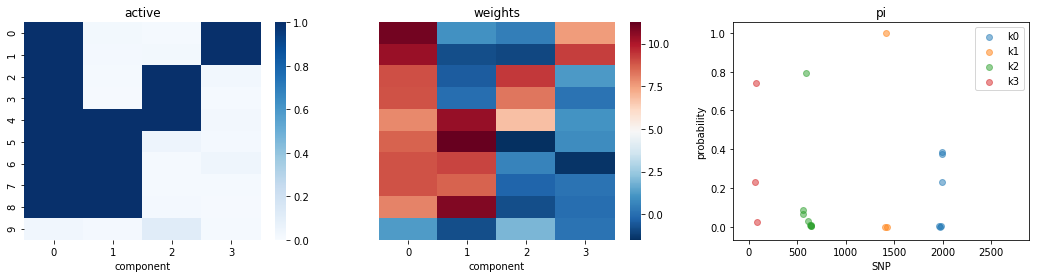

In [71]:
model.plot_components()

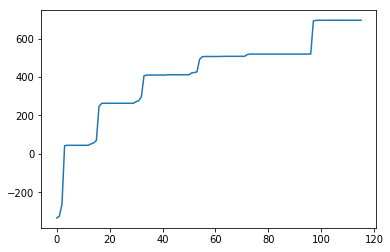

In [30]:
plt.plot(model.elbos)

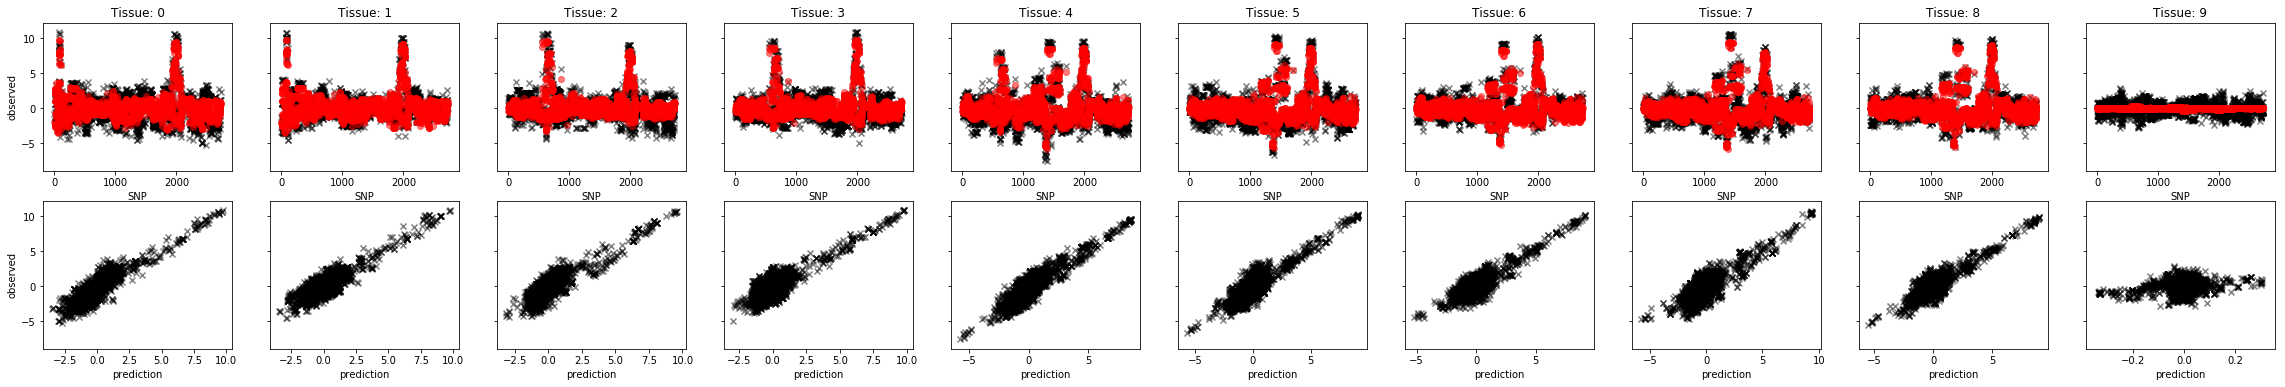

In [31]:
model.plot_predictions()

`plot_assignment_kl()` plots the pairwise KL divergences between the posterior inducing point assignments of each component. We would like to see that each component claims it's own set of SNPs so the divergences should be high. If multiple components are being used to describe effects at the same set of SNPs you should probably increase `prior_variance` so that the model can put larger weights on one of the components and drop the other.

`plot_credible_sets_ld(snps, alpha=0.9, thresh=0.1)` plots the LD matrix for the credible set of each component. Pick the top snps in each component so that their total probability sum to `> alpha`. Include components who have a minimum activity of `thresh` in at least one tissue. Optinally, you can provide a list of snp ids `snps` to also include in the plot.

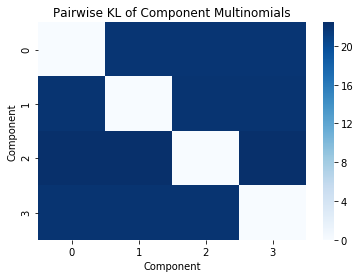

In [32]:
model.plot_assignment_kl()

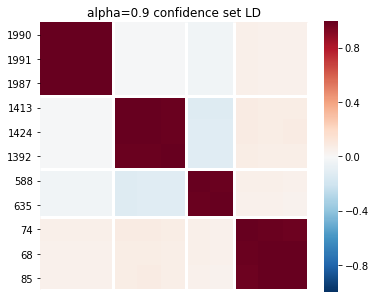

In [33]:
model.plot_credible_sets_ld()

### Looking at inducing points

Each component squeezes the data through one SNP. With a linear kernel we can think of this as a linear regression over SNPs with a single feature-- the correlation with some other SNP $z$. We put a categorical prior on $z$. Looking at the posterior shows us likely causal SNPs for the signal captured by that component

`get_top_snp_per_component()` returns the top SNP per component and the probability assigned to that snp

`get_confidence_sets(alpha=0.9, thresh=0.1)` returns, for each component, the top weighted snps so that $\sum p_i > \alpha$, 'thresh' filters out components with maximum assignment probability $ < \text{thresh}$

`get_pip()` returns the posterior inclusion probability of each snp in each tissue. this is the probability that a snp is active in a tissue through any (and potentially multiple, although in practice not) component

In [34]:
np.set_printoptions(precision=3, suppress=True)
top_snps, top_snp_probabilities = model.get_top_snp_per_component()
print('True causal snps {}\nTop SNP per component {}\nProbability of top SNP: {}'.format(causal_snps, top_snps, top_snp_probabilities))

True causal snps [  74  588 1413 1987]
Top SNP per component [1990 1413  588   74 2360 2360 2360 2360 2360 2360 2360 2360 2360 2360
 2360 2360 2360 2360 2360 2360]
Probability of top SNP: [0.352 0.739 0.846 0.441 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]


In [36]:
cs = model.get_credible_sets(0.99, thresh=0.5)
print('\n'.join(['component {}: {}'.format(key, cs[key]) for key in cs.keys()]))

component 0: [1990 1991 1987]
component 1: [1413 1424 1392 1406 1415 1398 1402]
component 2: [588 635 641 638]
component 3: [74 68 85]


### Colocalization

`get_A_in_B_coloc()` returns the pairwise probability that the set of active components in tissue A is a subset of the active components of tissue B

`get_A_equals_B_coloc()` return the pairwise probability that tissue A and tissues B have the exact same set of active components

`get_A_intersect_B_coloc()` return the pairwise probability that tissue A and tissue B both share at least one active component

`plot_colocalizations()` plot heatmaps for the above three events

In [37]:
model.plot_colocalizations()

### Real eQTL example

Now we show a quick run through a real eQTL exaple

In [39]:
def get_inputs(zscore_path, ld_path, afreq_path, gene):
    """
    zscore path: path to directory with zcore files [gene].zscore_matrix.txt'
    ld_path: path to directory with emprical correlation matrices of snps [gene]
    afreq_path: path to directory with allele frequency files, organized by chromosome
    """
    if zscore_path[-1] == '/':
        zscore_path = zscore_path[:-1]
    if ld_path[-1] == '/':
        ld_path = ld_path[:-1]
    if afreq_path[-1] == '/':
        afreq_path = afreq_path[:-1]

    X = pd.read_csv('{}/{}'.format(ld_path, gene), index_col=0)
    zscores = pd.read_csv('{}/{}.zscore_matrix.txt'.format(zscore_path, gene), '\t', index_col=0)

    nan_snps = np.all(np.isnan(X.values), axis=1)
    X = X.iloc[~nan_snps].iloc[:, ~nan_snps]

    active_snps = np.isin(X.index, zscores.index)
    X = X.iloc[active_snps].iloc[:, active_snps]

    active_snps = np.isin(zscores.index, X.index)
    Y = zscores.iloc[active_snps]
    Y = Y.iloc[:, ~np.any(np.isnan(Y.values), 0)]

    tissues = Y.columns.values
    snp_ids = Y.index.values
    pos = np.array([int(snp_id.split('_')[1]) for snp_id in snp_ids])

    Y = Y.T.values
    X = X.values
    X = (X + np.eye(X.shape[0])*1e-6) / (1+1e-6)

    # flip sign of zscore if alternate allele is major
    chrom = snp_ids[0].split('_')[0][3:]
    afreq = pd.read_csv('{}/chrom{}.afreq'.format(afreq_path, chrom))

    sign = np.ones(snp_ids.size)
    sign[afreq.set_index('ID').loc[snp_ids].ALT_FREQS > 0.5] = -1
    Y = Y * sign
    X = X * np.outer(sign, sign)

    return X, Y, tissues, snp_ids

In [40]:
gene = 'ENSG00000073464.11'
#gene = 'ENSG00000141644.17'
#gene = 'ENSG00000164904.17'

In [23]:
ld_path = '../marios_correlation_matrices/'
zscoore_path = '../data/zscore_genes_for_Karl/'
afreq_path = '../data/afreq/'

X, Y, tissues, snp_ids = get_inputs(zscoore_path, ld_path, afreq_path, gene)
T, N = Y.shape

In [117]:
%%time
K = 20
prior_activity = np.exp(-1*np.linspace(2, 2, K))
model = SpikeSlabSER(X, Y, K, snp_ids, tissues, prior_activity, 10.0)

model.weights = np.zeros_like(model.weights)
model.forward_fit(early_stop=True, max_inner_iter=1)

Forward fit, learning 1 components
Forward fit, learning 2 components
Forward fit, learning 3 components
Forward fit, learning 4 components
Forward fit, learning 5 components
Forward fit, learning 6 components
Forward fit, learning 7 components
Forward fit, learning 8 components
learned inactive cluster, finalizing parameters
CPU times: user 45.6 s, sys: 47.1 ms, total: 45.7 s
Wall time: 11.4 s


In [123]:
prior_activity

array([0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
       0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
       0.135, 0.135])

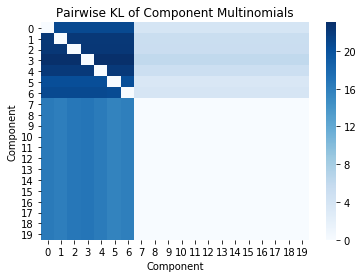

In [118]:
model.plot_assignment_kl()

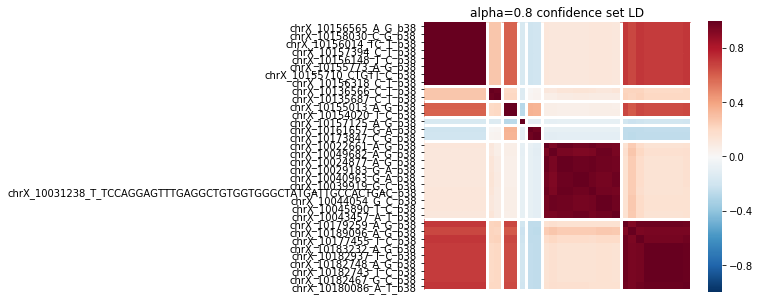

In [119]:
model.plot_credible_sets_ld(alpha=0.8)

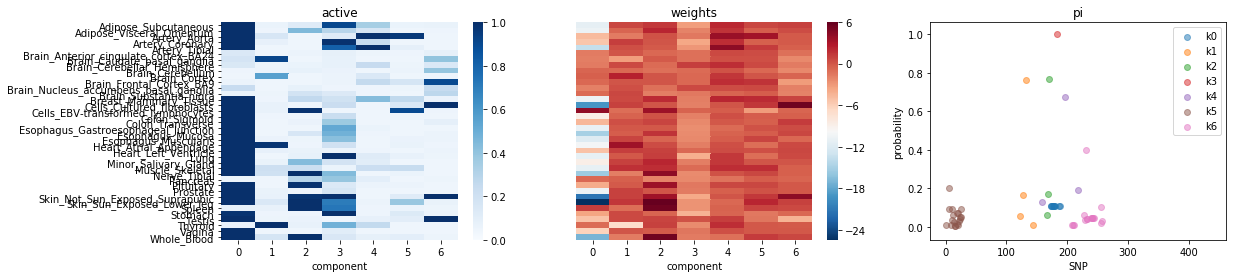

In [120]:
model.plot_components()

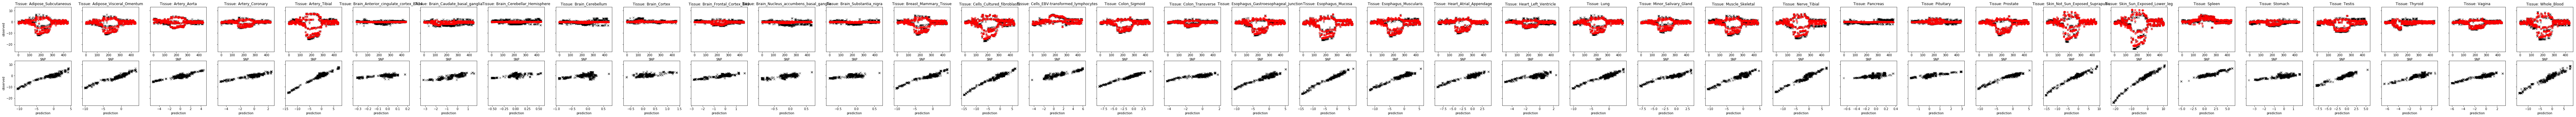

In [121]:
model.plot_predictions()

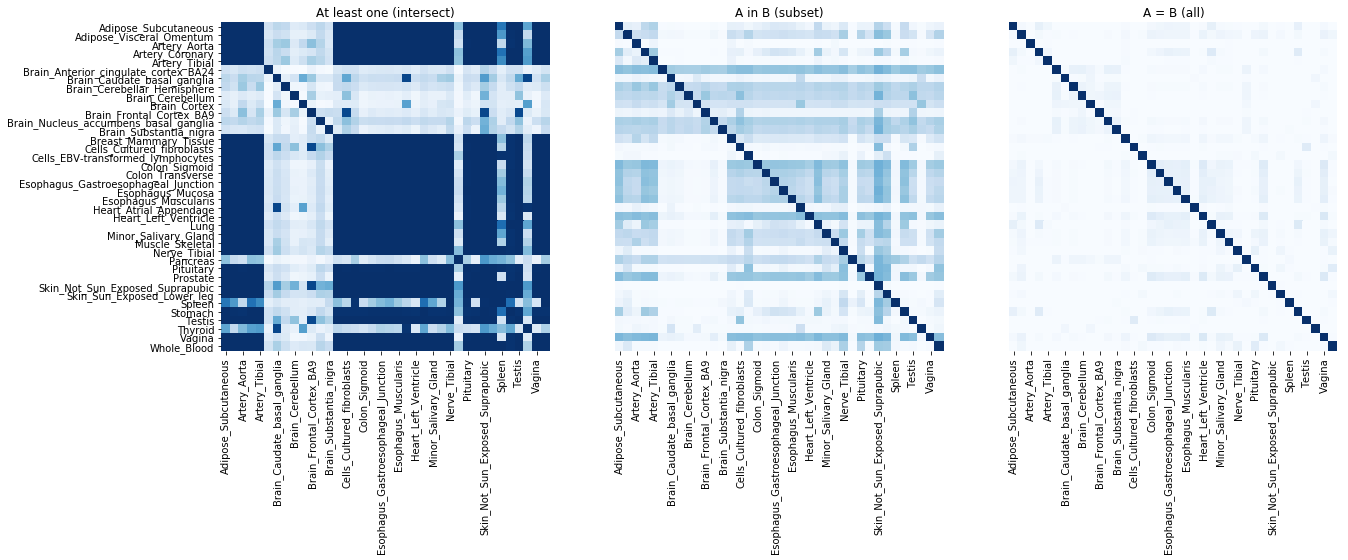

In [122]:
model.plot_colocalizations()

In [98]:
pip = model.get_pip()

In [99]:
pip.max(1).sort_values()

chrX_10196969_G_T_b38        0.000498
chrX_10194184_G_A_b38        0.000500
chrX_10219327_G_A_b38        0.000531
chrX_10097308_TCG_T_b38      0.000535
chrX_10232388_G_A_b38        0.000537
chrX_10145436_A_C_b38        0.000542
chrX_10123042_C_T_b38        0.000543
chrX_10130337_C_T_b38        0.000544
chrX_10236227_T_A_b38        0.000545
chrX_10088912_C_T_b38        0.000545
chrX_10215625_C_G_b38        0.000548
chrX_10218321_T_C_b38        0.000549
chrX_10215485_T_C_b38        0.000549
chrX_10097910_G_C_b38        0.000551
chrX_10217267_A_C_b38        0.000551
chrX_10098347_G_C_b38        0.000553
chrX_10246591_G_A_b38        0.000555
chrX_10085602_G_A_b38        0.000557
chrX_10100436_T_G_b38        0.000559
chrX_10302080_T_TA_b38       0.000560
chrX_10301764_T_G_b38        0.000562
chrX_10272352_A_G_b38        0.000563
chrX_10219080_T_G_b38        0.000563
chrX_10267985_A_G_b38        0.000564
chrX_10096569_G_A_b38        0.000565
chrX_10102097_G_A_b38        0.000565
chrX_1015618

In [58]:
model.snp_ids[model.pi[:, 4].argmax()]

'chrX_10157125_A_G_b38'

In [33]:
t = 0
snp = 4

pip = np.zeros((N, T))
for t in range(T):
    for n in range(N):
        pip[n, t] = 1 - np.exp(np.sum(np.log(1 - model.pi[n] * model.active[t])))
        
return pip

SyntaxError: 'return' outside function (<ipython-input-33-bb57265bd051>, line 9)

In [ ]:
sns.heatmap(pip[pip.max(1) > 0.1])

In [ ]:
model.active[t]

In [ ]:
model.active

In [ ]:
model.weights.shape, np.isnan(model.Y).shape

In [ ]:
model.plot_manhattan(component=3, thresh=0.5)

In [ ]:
model.get_component_colocalization(0)

In [ ]:
model.get_global_colocalzation()